# Before reading

This kernel is a Korean translation of [the kernel written by Chris Deotte][1].  
이 커널은 [Chris Deotte님이 작성한 커널][1]을 한국어로 번역한 것입니다.


[1]: https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

# XGB Fraud with Magic scores LB 0.96
이 모델은 캐글의 "IEEE-CIS Fraud Detection" 대회의 1등 솔루션의 부분입니다. 이 모델이 [Konstantin's][1] CatBoost 그리고 LGBM 모델과 앙상블 될 때, public LB 0.9677과 private LB 0.9459의 [결과][2]를 가져올 수 있습니다.  
  
이 커널에서는, 2가지 XGB 모델을 구축할 것입니다. 첫 번째 모델은 magic features를 사용하지 않고, LB 0.96을 성취했습니다. 두 번째 모델은 magic features를 사용하여 LB 0.96을 성취했습니다. 부록에서 post processing을 통해 어떻게 LB를 더 향상시켰는지에 대해 입증하고 있습니다.  
  
pandas와 CPU를 사용하여 디스크로부터 백만개의 row 데이터를 읽고 feature를 조정하는 것은 5분정도 소요됩니다. 이것의 대안으로 RAPIDS cuDF와 GPU를 사용한다면, 오직 20초밖에 소요되지 않습니다! CPU 시간은 코드블럭 아래에 표시되었고, GPU가 15배 빠르다는 것이 [여기][3]서 입증되었습니다.
  

[1]: https://www.kaggle.com/kyakovlev
[2]: https://www.kaggle.com/c/ieee-fraud-detection/leaderboard
[3]: https://www.kaggle.com/cdeotte/rapids-feature-engineering-fraud-0-96/

# How the Magic Works
Magic은 2가지 입니다. 첫 번째로 우리는 클라이언트(credit cards)를 인식할 수 있는 UID 변수가 필요합니다. 두 번째로 우리는 집계된 그룹(aggregated group) features를 만들 필요가 있습니다. 그러고 나서 UID를 삭제할 것입니다. 우리가 아래처럼 10가지 트랜잭션 `A, B, C, D, E, F, G, H, I, J`을 가진다고 가정해봅시다. 

![1](https://user-images.githubusercontent.com/37873745/76934497-935f5080-6932-11ea-8452-abe4c72bab0c.jpg)

만약 우리가 FeatureX만 사용한다고 하면, 우리는 70%의 트랜잭션만 올바르게 구분할 수 있을 것입니다. 아래, 노란색 원이 'isFraud=1'이고, 파란색 원이 'isFraud=0' 트랜잭션 입니다.
아래 트리모델에서 왼쪽 child와 오른쪽 child를 구분하고 난 후에, 왼쪽 child를 'isFraud=1'로 예측하고 오른쪽 child를 'isFraud=0'로 예측합니다. 그러므로 10개 중 7개의 트랜잭션만 올바르게 예측됩니다.

![2](https://user-images.githubusercontent.com/37873745/76934499-95291400-6932-11ea-941c-01b9671beab8.jpg)

이제 우리는 그룹을 정의하고 있는 UID를 가지고, 각 그룹에 따른 FeatureX의 평균을 사용하여 집계(aggregated) feature를 만든다고 가정해봅시다. 우리는 이제 100% 완벽하게 트랜잭션을 구분해낼 수 있을 것 입니다. 이 결정트리에서 UID feature는 직접적으로 사용되지 않는 다는 것을 잊지마세요.

![3](https://user-images.githubusercontent.com/37873745/76934503-965a4100-6932-11ea-83dd-e16a9d930f75.jpg)




# Load Data
우리는 [상관관계 분석][1]에서 중복되었다고 판단된 219개의 V 컬럼을 제외하고 모든 데이터를 load 할 것입니다.

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

In [0]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [5]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 30.1 s, sys: 1.16 s, total: 31.3 s
Wall time: 31.3 s


# Normalize D Columns

D 컬럼들은 과거의 어느 시점으로 부터의 "time deltas" 입니다. 우리는 D 컬럼들은 과거의 그들의 시점을 나타내도록 변환할 것 입니다. 이렇게 하면 D 컬럼이 시간이 지날수록 증가하는 것을 막을 수 있습니다. 공식은 `D15n = Transaction_Day - D15`, `Transaction_Day = TransactionDT/(24*60*60)`입니다. 연산이 끝나면 -1을 곱해줍니다. 

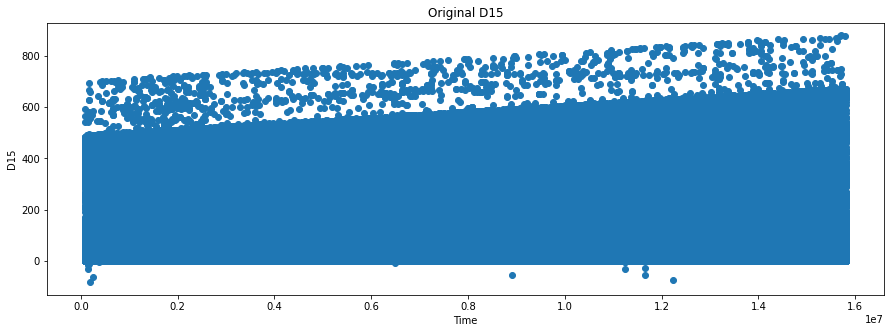

In [6]:
# PLOT ORIGINAL D
plt.figure(figsize=(15, 5))
plt.scatter(X_train.TransactionDT, X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [0]:
# NORMALIZE D COLUMNS
for i in range(1, 16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

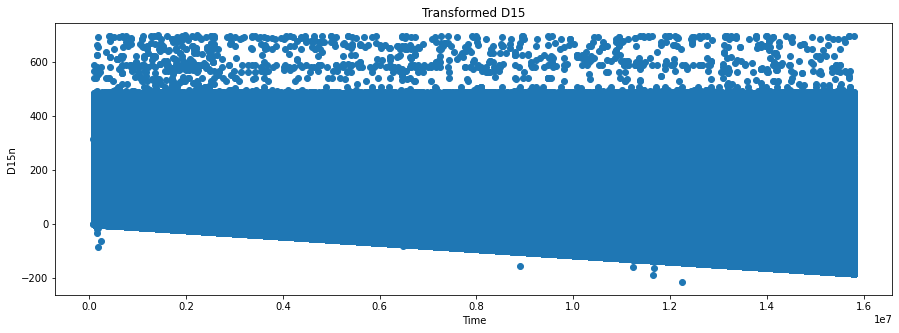

In [8]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [9]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 3 s, sys: 63.6 ms, total: 3.07 s
Wall time: 2.96 s


# Encoding Functions
아래 5가지 인코딩 함수가 있습니다. (1) `encode_FE`는 frequency encoding 입니다. 먼저 train과 test set을 합치고, 인코딩합니다. (2) `encode_LE`는 카테고리 feature를 위한 label encoding 입니다. (3) `encode_AG`는 집계 평균, 표준편차 같은 집계된(aggregated) feature를 만듭니다. (4) `encode_CB`는 두 개의 컬럼을 합칩니다. (5) `encode_AG2`는 한 그룹 안의 한 feature에 대해 고유한 값이 얼마나 있는 가를 count하여 집계된(aggregated) feature를 만듭니다. Feature engineering에 대한 더 많은 설명은 [이 discussion][1]을 보시길 바랍니다.

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [0]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col], df2[col]])    # train, test 합침
        vc = df.value_counts(dropna=True, normalize=True).to_dict() # frequency 계산
        vc[-1] = -1         # NaN값에 대해서는 -1 유지
        nm = col + '_FE'    # 새로운 컬럼명 정의

        # mapping
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm, ', ', end='')

# LABEL ENCODE
def encode_LE(col, train=X_train, test=X_test, verbose=True):
    df_comb = pd.concat([train[col], test[col]], axis=0)    # train, test 합침
    df_comb, _ = df_comb.factorize(sort=True)   # Label encoding
    nm = col
    if df_comb.max() > 32000: # Label이 많은 경우
        train[nm] = df_comb[:len(train)].astype('int32')    
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test,
              fillna=True, usena=False):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column + '_' + col + '_' + agg_type # 새로운 컬럼명 정의
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1, main_column] = np.nan
                # Aggregation 계산
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                    columns={agg_type: new_col_name})
                temp_df.index = list(temp_df[col])          # index 지정
                temp_df = temp_df[new_col_name].to_dict()   # dictionary화

                # mapping
                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name] = test_df[col].map(temp_df).astype('float32')

                if fillna:
                    train_df[new_col_name].fillna(-1, inplace=True)
                    test_df[new_col_name].fillna(-1, inplace=True)

                print("'" + new_col_name + "'", ', ', end='')

# COMBINE FEATURES
def encode_CB(col1, col2, df1=X_train, df2=X_test):
    nm = col1 + '_' + col2 # 새로운 컬럼명 정의
    
    # 값 string 변환 후 combine
    df1[nm] = df1[col1].astype(str) + '_' + df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str) + '_' + df2[col2].astype(str)
    encode_LE(nm, verbose=True)
    print(nm, ', ', end='')

# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col] + [main_column]], test_df[[col] + [main_column]]], axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ', end='')
    

# Feature Engineering

이제 features를 조정해봅시다. 이 단계에서 선택되는 모든 features는 local validation AUC를 증가시켰기에 선택됩니다. Feature engineering 절차는 다음과 같이 진행됩니다. 먼저, 아이디어를 생각하고, 새로운 feature를 만듭니다. 그런 후에, 자신의 모델에 추가하고 local validation AUC가 증가하는지, 감소하는지 평가합니다. 만약 AUC가 증가하면 feature를 유지하고, 반대로 감소하면 feature를 삭제합니다.

In [11]:
%%time
# TRANSACTION ANT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1,CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train, X_test, ['addr1', 'card1', 'card2', 'card3', 'P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1', 'addr1')
encode_CB('card1_addr1', 'P_emaildomain')
# FREQUENCY ENCODE
encode_FE(X_train, X_test, ['card1_addr1', 'card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt', 'D9', 'D11'], ['card1', 'card1_addr1', 'card1_addr1_P_emaildomain'], ['mean', 'std'], usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 16.9 s, sys: 871 ms, total: 17.8 s
Wall time: 17.8 s


# Feature Selection - Time Consistency
우리는 위에서 새로운 28개의 feature를 추가했습니다. 그리고 우리는 벌써 [상관관계 분석][1]을 통해 219개의 V 컬럼들을 삭제했었습니다. 그러므로 우리는 현재 242 컬럼을 가지고 있습니다. 이제 각 242 feature에 대해 "time consistency"를 확인해보려 합니다. 우리는 242개의 모델을 만들었습니다. 각 모델은 training data의 첫 번째 달의 데이터로 학습되고, 오직 하나의 feature가 사용됩니다. 그리고 training data의 마지막 달의 데이터를 예측할 것입니다. 여기서 우리는 training AUC와 validation AUC 둘다 `AUC = 0.5`를 넘기길 원합니다. 결과로 19개의 feature가 이 테스트를 실패했고, 삭제됩니다. 추가적으로, 많은 NaN으로 이루어진 7개의 D 컬럼들을 삭제합니다. Feature selection에 대한 더 많은 기술들은 [여기][2]에 리스트되어 있습니다.


[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [0]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)

# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [13]:
print('NOW USING THE FOLLOWING', len(cols), 'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation
이 대회에서 우리는 local validation에 기반해서 시간을 사용하였습니다. 저는 training set의 첫 75%의 데이터를 사용하여 나머지 25%를 예측하는 과정을 통해 feature를 평가했습니다. Konstantin은 조금 다른 local validation을 수행했습니다. 그는 먼저 첫 4개월의 데이터로 사용하였고, 한 달을 건너뛴 나머지 데이터들을 예측하는 것으로 평가했습니다. 현재 216개의 feature를 사용한 XGB 모델은 Chris' local validation에서 AUC = 0.9363을, Konstantin's local validation에서 AUC = 0.9241을 달성했습니다. 이 결과는 [여기][1]와 [여기][2]에 작성되어 있듯 magic 없이 Konstantin의 LGBM이 달성한 AUC와 같다는 것을 알아두세요. 

[1]: https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
[2]: https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv

In [0]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [15]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

XGBoost version: 0.90
[0]	validation_0-auc:0.787465
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.87831
[100]	validation_0-auc:0.894923
[150]	validation_0-auc:0.907818
[200]	validation_0-auc:0.918978
[250]	validation_0-auc:0.925765
[300]	validation_0-auc:0.930157
[350]	validation_0-auc:0.933913
[400]	validation_0-auc:0.935322
[450]	validation_0-auc:0.935882
[500]	validation_0-auc:0.936412
[550]	validation_0-auc:0.936245
[600]	validation_0-auc:0.936186
Stopping. Best iteration:
[510]	validation_0-auc:0.936498



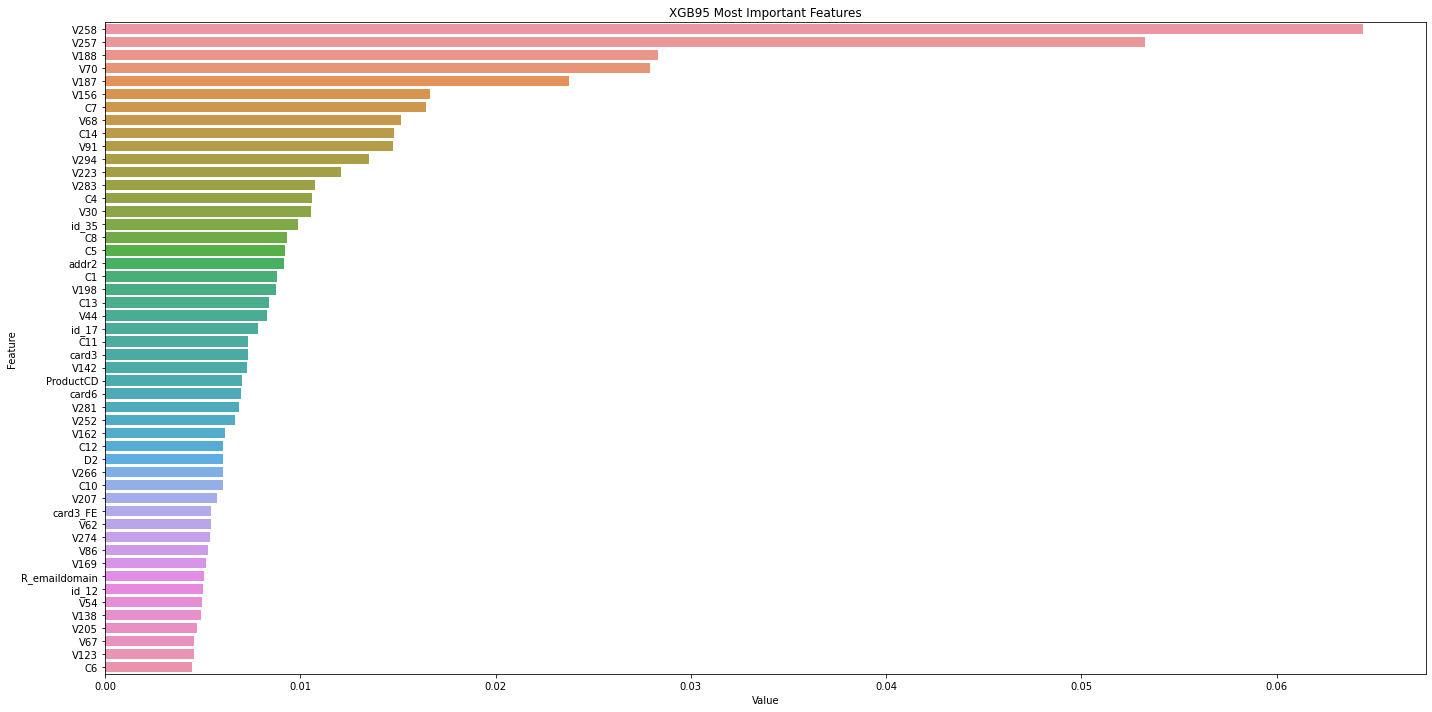

In [16]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

# Predict test.csv

우리는 달(month)을 그룹으로 하여 GroupKFold를 사용해 `test.csv`를 예측할 것입니다. Training data는 2017년 12월, 2018년 1월, 2018년 2월, 2018년 3월, 2018년 4월, 2018년 5월인 데이터로 이루어지며, 이러한 달을 12, 13, 14, 15, 16, 17로 나타낼 것입니다. GroupKFold의 첫 Fold는 달 13-17을 학습하고, 달 12를 예측합니다. 달 12의 목적은 XGB에게 언제 `early_stop`하는지 알려주기 위한 것입니다. 우리는 사실 시간을 거꾸로해서 예측해가는 것에 대해 걱정하지 않습니다. 달 13-17로 학습된 모델은 후의 시간인 `test.csv`도 잘 예측할 것입니다. 
  
우리는 feature를 결정하기 위해 Local validation을 사용했고, `test.csv`를 예측하기 위해 GroupKFold를 사용했습니다. 다른 많은 예측방법들을 수행했었으나, GroupKFold가 가장 좋은 결과를 가져왔습니다.


In [0]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month # 12~17

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month # 12~17

In [20]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
        # idxT: Train index, idxV: test index
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold', i, 'withholding month', month)
        print(' rows of train =', len(idxT), 'rows of holdout =', len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist'
        )
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                    eval_set=[(X_train[cols].iloc[idxV], y_train.iloc[idxV])],
                    verbose=100, early_stopping_rounds=200)
        
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:, 1]
        preds += clf.predict_proba(X_test[cols])[:, 1] / skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print('XGB95 OOF CV=', roc_auc_score(y_train, oof))

[137321 137322 137323 ... 590537 590538 590539]
[     0      1      2 ... 137318 137319 137320]
Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.757194
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.871064
[200]	validation_0-auc:0.891903
[300]	validation_0-auc:0.903162
[400]	validation_0-auc:0.907815
[500]	validation_0-auc:0.908778
[600]	validation_0-auc:0.909002
[700]	validation_0-auc:0.908893
[800]	validation_0-auc:0.908375
Stopping. Best iteration:
[612]	validation_0-auc:0.909398

[     0      1      2 ... 590537 590538 590539]
[315927 315928 315929 ... 417556 417557 417558]
Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.832247
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.906362
[200]	validation_0-auc:0.929236
[300]	validation_0-auc:0.940343
[400]	validation_0-auc:0.944656
[500]	validation_0-au

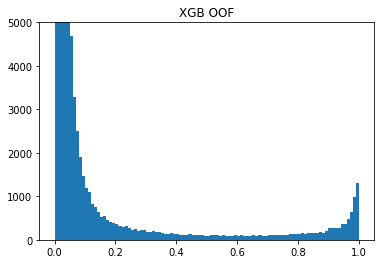

In [21]:
if BUILD95:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()
    # 그림을 봤을 때, 0.5 이하의 값이 더 많은 것을 볼 수 있다.

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_95.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)
    
else: X_train['oof'] = 0

# Kaggle Submission File XGB_95

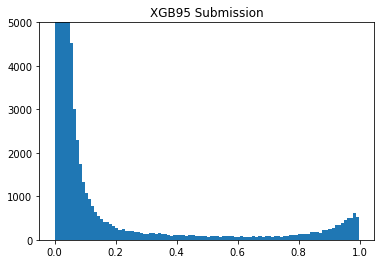

In [22]:
if BUILD95:
    sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_95.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()
    # train set의 시각화 부분과 비슷한 형태

![image](http://www.playagricola.com/Kaggle/9510.png)

# The Magic Feature - UID
  
우리는 이제 MAGIC FEATURES를 만들고 사용해볼 것 입니다. 먼저 우리는 모델에서 클라이언트(credit cards)를 찾을 수 있도록 도와주는 UID를 생성합니다. 이 UID는 완벽하지 않습니다. 많은 UID가 2개 이상의 클라이언트 값을 가지고 있습니다. 그러나 우리의 모델은 이것을 감지할 것이고, 트리를 사용한 많은 분기를 더해줌으로써 이 UID를 나누면서 단일 클라이언트(credit cards)를 찾을 것 입니다.

In [0]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

# Group Aggregation Features
  
우리의 모델에서 새로운 UID를 사용하기 위해, 많은 집계 그룹 (aggregated group) features를 만드는 것이 필요합니다. 여기서 우리는 47개의 새로운 features를 추가했습니다! 노트북 소개 부분의 그림이 이 작업을 왜 하는지에 대해 설명하고 있습니다. 집계(aggregation) 후에, 우리는 모델에서 UID를 삭제할 것입니다. 직접적으로 UID는 사용하지 않습니다.

In [25]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 2min 33s, sys: 2.92 s, total: 2min 35s
Wall time: 2min 35s


In [0]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [27]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 263 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation
  
새로운 magic features가 포함된 상태로 local validation을 수행할 것입니다. 이제 Chris' local validation은 AUC = 0.9472 그리고 Konstantin's local validation은 AUC = 0.9343 을 달성했습니다. Magic feature 없이는 AUC = 0.9363 과 AUC = 0.9241 을 달성했던 것을 기억하시나요? 우리는 2개의 validation 모두 AUC 0.01을 얻었고, 이를 통해 LB는 0.95에서 0.96으로 증가하였습니다. Magic feature를 포함한 Konstantic의 LGBM에서 Konstantin local validation은 AUC = 0.9377를 달성했습니다. [여기][1]

[1]: https://www.kaggle.com/kyakovlev/ieee-basic-fe-part-1

In [0]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [31]:
if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.81697
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.890905
[100]	validation_0-auc:0.907093
[150]	validation_0-auc:0.92244
[200]	validation_0-auc:0.933128
[250]	validation_0-auc:0.939618
[300]	validation_0-auc:0.943744
[350]	validation_0-auc:0.946104
[400]	validation_0-auc:0.946865
[450]	validation_0-auc:0.947249
[500]	validation_0-auc:0.947612
[550]	validation_0-auc:0.947615
[600]	validation_0-auc:0.94756
Stopping. Best iteration:
[513]	validation_0-auc:0.947723



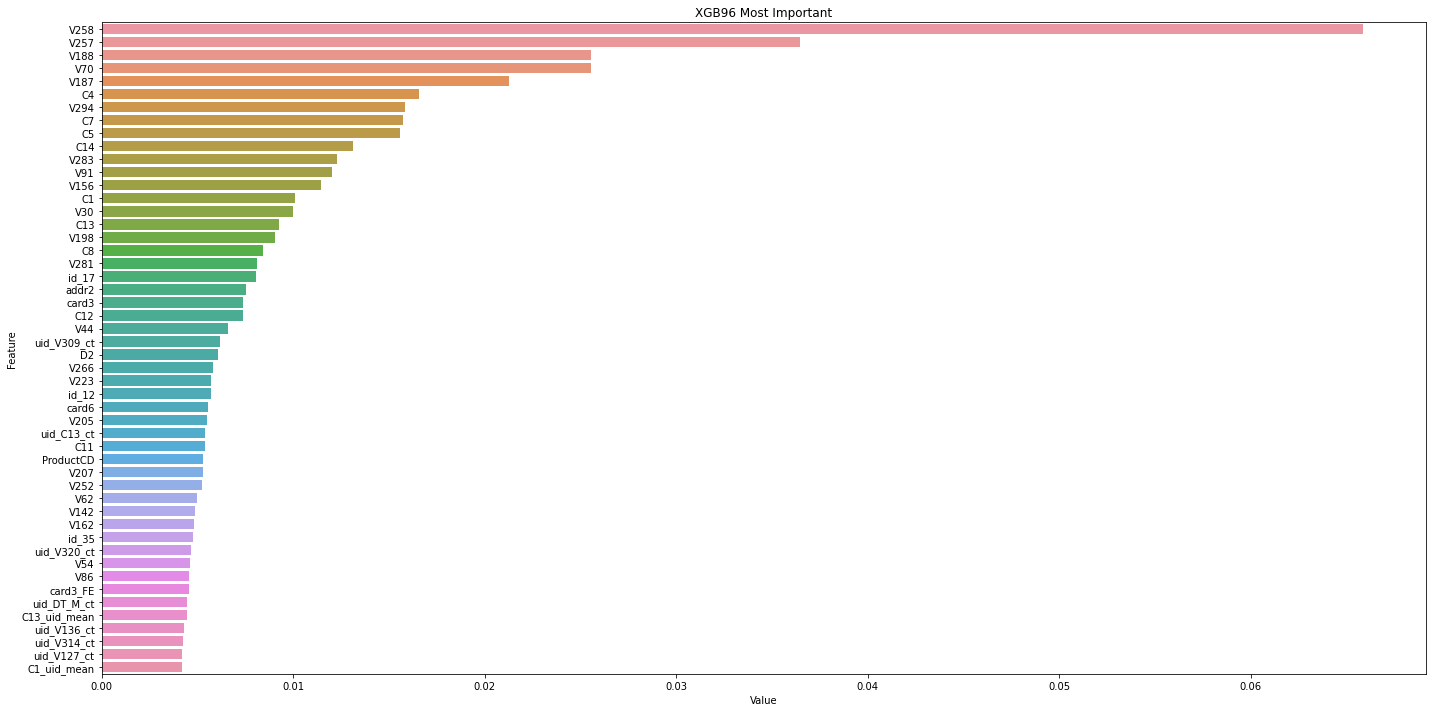

In [32]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()
        
    del clf, h; x=gc.collect()

# Predict test.csv

In [33]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.799536
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.89642
[200]	validation_0-auc:0.914381
[300]	validation_0-auc:0.920976
[400]	validation_0-auc:0.922624
[500]	validation_0-auc:0.923177
[600]	validation_0-auc:0.924076
[700]	validation_0-auc:0.924289
[800]	validation_0-auc:0.924141
[900]	validation_0-auc:0.924113
[1000]	validation_0-auc:0.925044
[1100]	validation_0-auc:0.925214
[1200]	validation_0-auc:0.92553
[1300]	validation_0-auc:0.925914
[1400]	validation_0-auc:0.926252
[1500]	validation_0-auc:0.92632
[1600]	validation_0-auc:0.926778
[1700]	validation_0-auc:0.926912
[1800]	validation_0-auc:0.927131
[1900]	validation_0-auc:0.92732
[2000]	validation_0-auc:0.927354
[2100]	validation_0-auc:0.927507
[2200]	validation_0-auc:0.927885
[2300]	validation_0-auc:0.928166
[2400]	validation_0-auc:0.928257
[2500]	validation_0-auc:0.92862
[2600]	validation

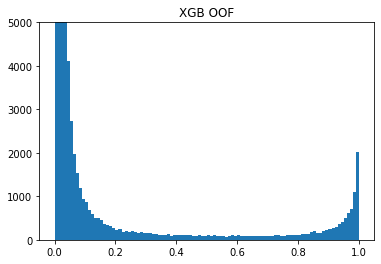

In [34]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

# Kaggle Submission File XGB_96

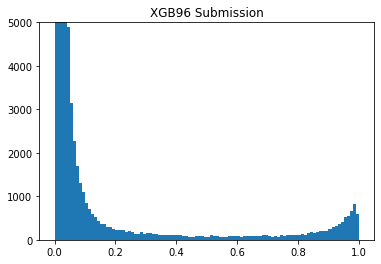

In [35]:
if BUILD96:
    sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_96.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()

![image](http://playagricola.com/Kaggle/9600.png)

# Post Process File XGB_96_PP
  
저희의 마지막 submission은 XGB, CatBoost 그리고 LGBM의 앙상블입니다. 여기에 CatBoost와 LGBM은 load하지 않았지만, 후처리에 대해 보여줄 것입니다. Konstantin은 정확한 UIDs (`card1_addr1_D1n`보다 더 정확한)를 찾는 [스크립트]를 작성했습니다. 저희는 각 uid가 클라이언트(credit card)를 나타낸다고 믿습니다. 분석에서는 한 client(Konstantin의 UID 중 하나)로 부터 이루어진 모든 트랜잭션은 다 `isFraud=0` 또는 다 `isFraud=1`이라는 것을 보여줍니다. 다시 말해서, 그들의 모든 예측은 다 같다는 것입니다. 그러므로 저희의 후처리는 한 클라이언트로 부터 이루어진 모든 예측을 train 데이터셋의 `isFraud` 값을 포함한 그들의 예측 평균으로 대체할 것입니다. 저희는 2가지 좀 다른 버전을 가지고 있고, 이 것들을 순서적으로 적용합니다.
  
저희의 XGB 모델에 후 처리를 적용한 것은 Public LB를 0.9602에서 0.9618 로 증가시켰습니다. 그리고 Private LB를 0.9324에서 0.9341 로 증가시켰습니다. LB 0.0016 향상을 이뤄냈습니다.


[1]: https://www.kaggle.com/kyakovlev/ieee-uid-detection-v6

In [0]:
X_test['isFraud'] = sample_submission.isFraud.values
X_train['isFraud'] = y_train.values
comb = pd.concat([X_train[['isFraud']],X_test[['isFraud']]],axis=0)

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v4_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid2'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid2').isFraud.agg(['mean'])
comb.loc[comb.uid2>0,'isFraud'] = comb.loc[comb.uid2>0].uid2.map(mp['mean'])

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v1_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid3'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid3').isFraud.agg(['mean'])
comb.loc[comb.uid3>0,'isFraud'] = comb.loc[comb.uid3>0].uid3.map(mp['mean'])

sample_submission.isFraud = comb.iloc[len(X_train):].isFraud.values
sample_submission.to_csv('sub_xgb_96_PP.csv',index=False)

![image](http://playagricola.com/Kaggle/xgbpp.png)